In [1]:
%cd /home/luke-padmore/Source/flow-matching-mnist

/home/luke-padmore/Source/flow-matching-mnist


In [2]:
import torchvision
import math
import torch
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.unet import UNet, CondUNet
import os, sys
from models.ode_solvers import euler_solver, rk2_solver
from pathlib import Path 
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Pad(2,padding_mode='constant'),
    transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=True,
                                      download=True,
                                      transform=transform)
trainloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

testset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=False,
                                      download=True,
                                      transform=transform)
testloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

## Plotting a grid of images

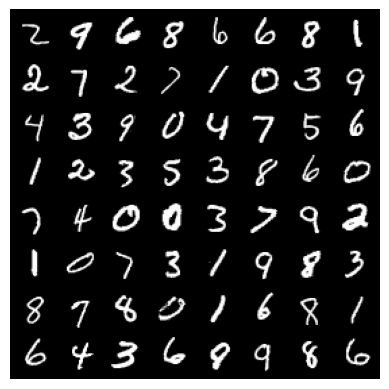

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8)

plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

## Testing training objective

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet([1,32,64,128],8,8,8,128).to(device).to(device)

In [4]:
def vf_learned(model):
    def f(x,t):
        t_tensor = torch.full((x.shape[0], 1, 1, 1), fill_value=t, device=x.device)
        return model(x, t_tensor)
    return f

torch.manual_seed(0)
x0 = torch.randn_like(images).to(device)
# ts,xs = euler_solver(vf_learned(model),x0,0.0,1.0,1000)
ts,xs = rk2_solver(vf_learned(model),x0,0.0,1.0,50)

NameError: name 'images' is not defined

In [ ]:
grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8, padding = 2)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

NameError: name 'torchvision' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2650357..1.367075].


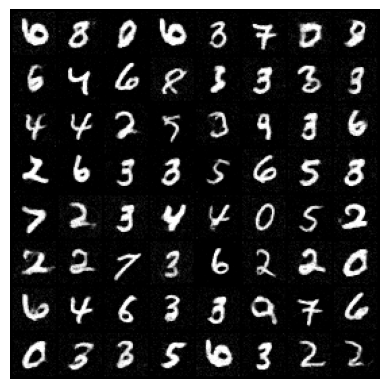

In [ ]:
grid = torchvision.utils.make_grid((xs[-1].cpu() + 1)/2,nrow = 8)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

## Testing overfitting to a single batch

In [4]:
from utils.train import flow_matching_step_cfg
from tqdm import tqdm
loss_fn = torch.nn.MSELoss()
optim = torch.optim.AdamW(params = model.parameters(),lr = 1e-3)
flow_matching_step_cfg(model,images,labels,0.2,10,loss_fn,device)
model.train()
for epoch in tqdm(range(1000)):
    optim.zero_grad()
    mse = flow_matching_step_cfg(model,images,labels,0.2,10,loss_fn,device)
    mse.backward()
    optim.step()
    if epoch % 100 == 0:
        print(f'Loss = {mse.item()}')

NameError: name 'model' is not defined

## Testing classifier guidance sampling
Needs debugging :(

In [8]:
from models.ode_solvers import make_vf_cfg, create_samples
from torchvision.utils import make_grid
model = model.to(device)
# f = make_vf_cfg(model,labels,w=1,NULL_ID=10)
samples = create_samples(64,(1,32,32),rk2_solver,f,50,device=device)

grid = torchvision.utils.make_grid((samples + 1) / 2,nrow = 8).detach().cpu()

plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

NameError: name 'model' is not defined

## Testing Conditional UNet

In [5]:
from utils.train import train_loop_cfg
from models.unet import CondUNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CondUNet([1,32,64,128],11,8,8,8,128).to(device).to(device)
train_loop_cfg(model,trainloader,NULL_ID = 10,num_epochs=1)

100%|██████████| 1/1 [00:36<00:00, 36.64s/it]
2025/11/22 15:51:26 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: TypeError('The PyTorch flavor does not support List or Dict input types. Please use a pandas.DataFrame or a numpy.ndarray'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`. To disable automatic signature inference, set `signature` to `False` in your `log_model` or `save_model` call.
2025/11/22 15:51:32 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "x": [
      [
        [
          [
            -1.9322257041931152,
            -0.3288767337799072,
            -1.485710620880127,
            0.4486270248889923,
            1.6035841703414917,
            -0.1871815323829651,
            -2.5157012939453125,
            1.1095821857452393,
            1.0564937591552734,
            1.0732321739196777,
         